### MLP-pitmodel

test the new feature 'cur_cautionlaps'

base: MLP-pitmodel-plen2

build a pitstop dataset with <cautions_laps, pitage, gap2nextpit>
gluonts interface of Dataset = Iterable[DataEntry], DataEntry = Dict(str, any)

+ input pitstop dataset, remove pitstops with pit_oncaution = 1, refer to lapstatus_dataset-fastrun
+ context_length = 1, prediction_length = 1
+ target : gap to nextpit
+ covariates are: cautions_laps, pitage, (carid, eid)
+ modeling the distribution of nextpit-gap


In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import random
import mxnet as mx
from mxnet import gluon
import pickle
import json
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import inspect
from scipy import stats
from pathlib import Path 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from gluonts.dataset.util import to_pandas
from pathlib import Path
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator, MultivariateEvaluator
from gluonts.model.predictor import Predictor
from gluonts.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.distribution.student_t import StudentTOutput
from gluonts.model.forecast import SampleForecast

from indycar.model.mlp import MLPEstimator

INFO:root:Using GPU


In [2]:
import os
os.getcwd()

'/scratch_hdd/hpda/indycar/notebook/23.experiments'

In [3]:

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

def test_flag(a, bitflag):
    return (a & bitflag) ==  bitflag

#
# remove NaN at the tail
# there should be no nans in the middle of the ts
COL_LAPTIME=0
COL_RANK=1
COL_TRACKSTATUS=2
COL_LAPSTATUS=3
COL_TIMEDIFF=4
COL_CAUTION_LAPS_INSTINT=5
COL_LAPS_INSTINT= 6
COL_ELAPSED_TIME= 7
COL_LAP2NEXTPIT = 8


MODE_ORACLE = 0
MODE_NOLAP = 1
MODE_NOTRACK = 2
MODE_TESTZERO = 4
MODE_TESTCURTRACK = 8
#MODE_STR={MODE_ORACLE:'oracle', MODE_NOLAP:'nolap',MODE_NOTRACK:'notrack',MODE_TEST:'test'}

def split_ts(rec, carno, eid, include_end = False):
    """
    input: 
        ts
    output:
        nextpit records
    """
    output = []
    pitstops = np.where(rec[COL_LAPSTATUS,:] == 1)[0]
    
    if len(pitstops)==0:
        print('no pit ts')
        return output
    
    #pit_oncaution = np.zeros_like((pitstops))
    #for pit in pitstops:
    #    if rec[COL_TRACKSTATUS,:] == 1:
    #        pit_oncaution = 1
    pit_oncaution = np.zeros_like((rec[COL_LAP2NEXTPIT,:]))
    stint_len = np.zeros_like((rec[COL_LAP2NEXTPIT,:]))
    pos = 0
    for pit in pitstops:
        if rec[COL_TRACKSTATUS,pit] == 1:
            #next pit is oncaution
            # set pos -> pit as oncaution
            pit_oncaution[pos:pit] = 1
        else:
            pit_oncaution[pos:pit] = 0
            
        stint_len[pos:pit] = pit - pos
        pos = pit
        
        
    # calc cur_cautionlaps
    # accumulate consecutive caution laps
    trackstatus = rec[COL_TRACKSTATUS,:]
    lapstatus = rec[COL_LAPSTATUS,:]
    
    #import pdb; pdb.set_trace()
    
    cur_cautionlaps = np.zeros_like(trackstatus)
    cautionlaps_acc = 0
    for idx in range(len(trackstatus)):
        if (trackstatus[idx] == 0) or (lapstatus[idx] == 1):
            #reset
            cautionlaps_acc = 0
        else:
            cautionlaps_acc += 1
            
        #save state
        cur_cautionlaps[idx] = cautionlaps_acc
        
            
    #prepare output : lap2nextpit, CAUTION_LAPS_INSTINT,LAPS_INSTINT, pit_oncaution, carno, eid, lap, stintlen
    if include_end:
        #rec = rec[:, ~np.isnan(rec[run_ts,:])]
        totallen = len(rec[COL_RANK, ~np.isnan(rec[COL_RANK,:])])
    else:
        totallen = pitstops[-1]
        
    # set the last stint target = 999, an invalid lap2nextpit
    for idx in range(totallen):
        output.append([ rec[COL_LAP2NEXTPIT ,idx] if idx < pitstops[-1] else 999
                        ,rec[COL_CAUTION_LAPS_INSTINT ,idx]
                        ,rec[COL_LAPS_INSTINT ,idx]
                        ,pit_oncaution[idx]
                        ,carno
                        ,eid
                        ,idx
                        ,stint_len[idx]
                        ,cur_cautionlaps[idx]
                      ])
        
    return output

def make_dataset_byevent(test_event = 'Indy500-2018', include_end = False):
    """
    split the ts to train and test part by the ratio
    
    oracle_mode: false to simulate prediction in real by 
        set the covariates of track and lap status as nan in the testset
            
    
    """    
    useeid = False
    run_ts = COL_LAP2NEXTPIT
    train_set = []
    test_set = []
    
    #_data: eventid, carids, datalist[carnumbers, features, lapnumber]->[laptime, rank, track, lap]]
    for _data in laptime_data:
        _train = []
        _test = []
        
        if events[_data[0]] == test_event:
            test_mode = True
        elif _data[0] in _train_events:
            test_mode = False
        else:
            print('skip event:', events[_data[0]])
            continue
            
        # process for each ts
        for rowid in range(_data[2].shape[0]):
            # rec[features, lapnumber] -> [laptime, rank, track_status, lap_status,timediff]]
            rec = _data[2][rowid].copy()
            
            #remove nan(only tails)
            nans, x= nan_helper(rec[run_ts,:])
            nan_count = np.sum(nans)             
            rec = rec[:, ~np.isnan(rec[run_ts,:])]
            
            # remove short ts
            totallen = rec.shape[1]
            
            carno = _data[1][rowid]
            carid = global_carids[_data[1][rowid]]
            
            eid = _data[0]
            
            # all go to train set
            output = split_ts(rec, carno, eid, include_end= include_end)
            #if len(output) == 0:
            #    continue
            
            test_rec_cnt = 0
            if not test_mode:
                _train.extend(output)
                
            else:
                _test.extend(output)
                test_rec_cnt += 1
            
            #add one ts
            print(f'carno:{carno}, totallen:{totallen}, nancount:{nan_count}, test_reccnt:{test_rec_cnt}')

        train_set.extend(_train)
        test_set.extend(_test)

    print(f'train len:{len(train_set)}, test len:{len(test_set)}')
    
    return train_set, test_set

def save_dataset(datafile,freq, prediction_length, cardinality, train_ds, test_ds):
    with open(datafile, 'wb') as f:
        #pack [global_carids, laptime_data]
        savedata = [freq, prediction_length, cardinality, train_ds, test_ds]
        #savedata = [freq, train_set, test_set]
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

In [4]:
#make gluonts
from sklearn.preprocessing import StandardScaler,MinMaxScaler

def makedb(data, scaler='standard', perm = True, feature_cnt=2):
    db = []
    start = pd.Timestamp("01-01-2019", freq='1min')  # can be different for each time series
    
    scalers = {'minmax':MinMaxScaler(), 'standard':StandardScaler()}
    
    if isinstance(scaler, str):
        if scaler in scalers:
            scaler = scalers[scaler]
            scaler.fit(data)
            df = scaler.transform(data)
        else:
            # no scaler
            df = data
    else:
        #use input scaler
        #scaler.fit(data)
        df = scaler.transform(data)
        
    
    #permute
    if perm:
        perm = np.random.permutation(len(df))
        df = df[perm]
    
    for x in df:
        if feature_cnt == 3:
            db.append({'target':np.array([x[0]]), 'feat':np.array([x[1],x[2],x[3]]),
                  "start":start, 'forecast_start':start})
        elif feature_cnt == 2:
            db.append({'target':np.array([x[0]]), 'feat':np.array([x[1],x[2]]),
                  "start":start, 'forecast_start':start})
        else:
            print('error _feature_cnt not support:', feature_cnt)
            break
        
    return db, scaler, df


def make_fulltestdb(scaler, maxgap=60, maxcautionlen=20, feature_cnt=2):
    db = []
    start = pd.Timestamp("01-01-2019", freq='1min')  # can be different for each time series

    data = []
    for caution_lap in range(maxgap):
        for pitage in range(caution_lap, maxgap):
            if feature_cnt == 2:        
                data.append([0.,caution_lap, pitage, 0])
            elif feature_cnt == 3:        
                for cur_cautionlap in range(0, caution_lap+1):
                    data.append([0.,caution_lap, pitage, cur_cautionlap])
    data = np.array(data)
    
    if not isinstance(scaler, str):
        df = scaler.transform(data)
    else:
        df = data
    
    #data
    print(f'make full testdb: {len(df)} records')
    for x in df:
        if feature_cnt == 3:        
            db.append({'target':np.array([x[0]]), 'feat':np.array([x[1],x[2],x[3]]),
                  "start":start, 'forecast_start':start})
        elif feature_cnt == 2:
            db.append({'target':np.array([x[0]]), 'feat':np.array([x[1],x[2]]),
                  "start":start, 'forecast_start':start})
        else:
            print('error _feature_cnt not support:', feature_cnt)
            break

    #reset data, used by PitModel.save_model()
    if feature_cnt == 2:
        data = data[:,:3]            
            
    return db, scaler, df, data

In [5]:
def train_model(epochs, layers=[10,10,5], output = 'student', dropout = .5, id='all', feature_cnt = 2):
    distr_outputs ={'student':StudentTOutput(),  
                    'negbin':NegativeBinomialOutput() 
                   }
    if not output in distr_outputs:
        print(f'distr_output: {output} not found error.')
        return
    
    distr_output = distr_outputs[output]
    
    modelid = f'mlp-{trainrace}-d%s-f%d-e%s-l%s-%s-d%s'%(id, feature_cnt,
                                            epochs, '-'.join([str(x) for x in layers]), output, dropout)
    
    estimator = MLPEstimator(
        num_hidden_dimensions=layers,
        prediction_length=1,
        context_length=1,
        freq='1min',
        dropout = dropout,
        distr_output = distr_output,
        trainer=Trainer(ctx="gpu(0)", 
                        batch_size = 32,
                        epochs= epochs,
                        learning_rate=1e-3,
                        hybridize=False,
                        num_batches_per_epoch=100
                       )
    )    

    predictor = estimator.train(train_ds)

    return predictor, modelid

def eval_model(predictor, test_ds):
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset    
        predictor=predictor,  # predictor                                  
        num_samples=1000,  # number of sample paths we want for evaluation 
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)     
    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9]) 
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
    print(json.dumps(agg_metrics, indent=4)) 
    return tss, forecasts, agg_metrics


def raw_eval(tss, forecasts):
    """
    scaler
    """
    #rec = np.zeros((_feature_cnt + 1))
    rec = np.zeros((4))

    truth, pred = [],[]
    #go through the dataset
    for idx in range(len(tss)):
        rec[0] = list(tss[idx].values)[0]
    
        if isinstance(scaler, str):
            truth.append(int(rec[0]))
        else:
            truth.append(int(scaler.inverse_transform(rec)[0]))
    
        rec[0] = np.mean(forecasts[idx].samples)
        
        if isinstance(scaler, str):
            pred.append(int(rec[0]))    
        else:
            pred.append(int(scaler.inverse_transform(rec)[0]))        

    #get mae
    mae = mean_absolute_error(truth, pred)
    print('mae = ', mae)
    return mae

def decode(tss, forecasts):
    """
    scaler
    """
    #rec = np.zeros((_feature_cnt + 1))
    rec = np.zeros((4))

    truth, pred = [],[]
    sampleCnt = forecasts[0].samples.shape[0]
    samples = np.zeros((sampleCnt, len(tss)))
    
    #go through the dataset
    for idx in range(len(tss)):
        rec[0] = list(tss[idx].values)[0]
    
        if isinstance(scaler, str):
            truth.append(int(rec[0]))
        else:
            truth.append(int(scaler.inverse_transform(rec)[0]))
    
        #pred
        rec[0] = np.mean(forecasts[idx].samples)
        
        if isinstance(scaler, str):
            pred.append(int(rec[0]))    
        else:
            pred.append(int(scaler.inverse_transform(rec)[0]))        
            
        #samples
        for sid in range(sampleCnt):
            rec[0] = forecasts[idx].samples[sid]
            if isinstance(scaler, str):
                pred.append(int(rec[0]))    
                samples[sid, idx] = int(rec[0])
            else:
                samples[sid, idx] = int(scaler.inverse_transform(rec)[0])        
    
    return truth, pred, samples

def save_model(predictor, outdir):
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    
    predictor.serialize(Path(outdir)) 


In [6]:
### pitmodel
class PitModel():
    """
     <caution_lap, pitage> -> [distribution]    
     distribution := sorted cdf [val:probability, val2:p2, ...]
         [0,:] -> val
         [1,:] -> cdf p
         
     no scaler, raw feat and target
    
    """
    def __init__(self, modelfile=''):
        self.model = {}
        self.name = ''
        
        if modelfile:
            self.load_model(modelfile)
                
    def load_model(self, modelfile):
        with open(modelfile, 'rb') as f:
            self.name, self.model = pickle.load(f, encoding='latin1')
            print(f'init model:{self.name}')
        
    def save_model(self, modelname, test_ds, forecasts, scaler):
        
        model = {}
        
        #get the sclaer for the first column(lap2nextpit)
        sc, scf = '', ''
        if isinstance(scaler, StandardScaler):
            sc = StandardScaler()
            sc.scale_ = scaler.scale_[0]
            sc.mean_ = scaler.mean_[0]
            sc.var_ = scaler.var_[0]

            scf = StandardScaler()
            scf.scale_ = scaler.scale_[1:]
            scf.mean_ = scaler.mean_[1:]
            scf.var_ = scaler.var_[1:]

        
        for idx, rec in enumerate(test_ds):
            feat = rec[1:]
                
            key = '-'.join([str(int(x)) for x in feat])
            
            if not key in model:
            
                samples = forecasts[idx].samples.reshape(-1)
                
                if not isinstance(sc, str):
                    samples = sc.inverse_transform(samples)
                
                #force to prediction to be valid lap2nextpit
                samples = samples.astype(int)
                samples = samples[samples > 0]

                #
                valset = set(list(samples))
                plen = len(valset)
                distr = np.zeros((2, plen))
                distr[0, :] = sorted(valset)
                smap = {val:id for id, val in enumerate(distr[0, :])}
                for s in samples:
                    distr[1,smap[s]] += 1
                tsum = np.sum(distr[1,:])
                distr[1, :] /= tsum
                distr[1, :] = np.cumsum(distr[1, :])

                model[key] = distr
                
        #save model
        self.model = model
        self.name = modelname
        with open(modelname, 'wb') as f:
            savedata = [self.name, self.model]
            pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)        
        print(f'save model {modelname} with {len(self.model)} keys.')
                
    def predict(self, *args):
        key = '-'.join([str(int(x)) for x in args])
        #if key in self.model:
        try:
            distr = self.model[key]
            
            #[0, 1.)
            p = np.random.random()  
            i = np.sum(distr[1,:] < p)
            
            return distr[0,i]
        except:
            #exception
            #todo, backto special model
            print(f'ERROR: key {key} not found in model')
                       
    def forecast_ds(self, test_ds, forecasts):
        """
        test_ds as testset, the unsclaed input
        forecasts ; the template
        """
        
        plen = len(test_ds)
        sample_cnt = forecasts[0].samples.shape[0]
        assert(plen == len(forecasts))
        

        #build a new forecasts object
        nf = []
        for fc in forecasts:
            nfc = SampleForecast(samples = np.zeros_like(fc.samples), 
                                 freq=fc.freq, start_date=fc.start_date)
            nf.append(nfc)
        
        for idx, rec in enumerate(test_ds):
            feat = rec[1:]
                    
            onecast = np.zeros((sample_cnt))
            for i in range(sample_cnt):
                #onecast[i] = self.predict(feat[0], feat[1],feat[2])
                onecast[i] = self.predict(*feat)
        
            nf[idx].samples = onecast

        return nf
    
    def forecast_onecar(self, test_ds, plen = 2, sample_cnt=100):
        """
        long-prediction for a single car
        
        input:
            test_df ; 'lap2nextpit','caution_laps','pitage','lap'
        """
        
        #assert for one car
        totallen = len(test_ds)
        start = pd.Timestamp("01-01-2019", freq='1min')  # can be different for each time series
        
        #samples
        #onecast = np.zeros((sample_cnt, totallen+plen))
        onecast = np.zeros((sample_cnt, totallen))
        #onecast = np.zeros((sample_cnt, maxlap))
        tss = np.zeros((totallen+plen))
        
        for idx, rec in enumerate(test_ds[:-plen]):
        #for idx in range(maxlap-plen):
            
            #if idx<len(test_ds):
            #    rec = test_ds[idx]
            #else:
            #    #use the last rec
            #    # target, cautionlaps, pitage, cur_curcautionlaps
            #    rec = [0, ] 
                
            target = rec[0]
            feat = rec[1:]
            
            if target == plen:
                tss[idx + plen] = 1
            
            for i in range(sample_cnt):
                nextpit = self.predict(*feat)
                                                    
                if nextpit == plen:
                    onecast[i, idx + plen] = 1
                
        forecast = SampleForecast(samples = onecast, 
                             freq='1min', start_date=start)

        return forecast, tss
    
    
def save_full_pitmodel(mid, scaler, maxgap=60, feature_cnt = 2):
    """
    input:
        p[mid]; predictor
        runid ; 'all' or 'sel' of the trainning set
    """
    
    #get scaler
    #scaler = _data[runid][-1]

    # make full test set
    test_ds, _, _, test_all = make_fulltestdb(scaler, maxgap = maxgap, feature_cnt = feature_cnt)

    tss,forecasts, _ = eval_model(p[mid], test_ds)

    pitmodel = PitModel()
    
    featurecnt_str = 'withcurcautionlaps' if (feature_cnt==3) else 'nocurcautionlaps'

    #pitmodel.save_model(f'pitmodel-m{maxgap}-{mid}.pickle', test_all, forecasts, scaler)
    pitmodel.save_model(f'{dataOutputRoot}/pitmodel-m{maxgap}-{mid}-1k-{featurecnt_str}.pickle', test_all, forecasts, scaler)

    return pitmodel

### create dbs

In [7]:
def build_datasets(test_event, include_end, sel_stintlen, noshort_stintlen, feature_cnt=2):
    """
    sel_stintlen, noshort_stintlen  ; lower bound of stint len
    
    """
    
    _data = {}
    
    train, test =  make_dataset_byevent(test_event = test_event, include_end = include_end)
    #prepare output : lap2nextpit, CAUTION_LAPS_INSTINT,LAPS_INSTINT, pit_oncaution, carno, eid, lap
    df_train = pd.DataFrame(train,columns=['lap2nextpit', 'caution_laps','pitage', 'pit_oncaution', 
                     'carno','eid','lap','stint_len','cur_cautionlaps'])
    df_test = pd.DataFrame(test,columns=['lap2nextpit', 'caution_laps','pitage', 'pit_oncaution', 
                     'carno','eid','lap','stint_len','cur_cautionlaps'])
    
    # select
    train_sel = df_train[(df_train['pit_oncaution']==0) &(df_train['stint_len']>sel_stintlen)]
    train_sel_2013_2017 = train_sel[train_sel['eid'].isin(_train_events)]
    train_all_2013_2017 = df_train[df_train['eid'].isin(_train_events)]

    print(len(train_all_2013_2017), len(train_sel_2013_2017))    

    test_sel = df_test[(df_test['pit_oncaution']==0) &(df_test['stint_len']>sel_stintlen)]
    test_all = df_test

    train_sel_noshort = df_train[(df_train['stint_len']>noshort_stintlen)]
    train_sel_noshort_2013_2017 = train_sel_noshort[train_sel_noshort['eid'].isin(_train_events)]
    test_sel_noshort = df_test[(df_test['stint_len']>noshort_stintlen)]    
    
    
    # selected db
    trainset = train_sel_2013_2017[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
    testset = test_sel[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
    train_ds, scaler, _ = makedb(trainset, scaler='standard',feature_cnt=feature_cnt)
    test_ds, _, _ = makedb(testset, scaler, perm=False,feature_cnt=feature_cnt)

    _data['sel'] = [trainset, testset, train_ds, test_ds, scaler]


    # selected db
    trainset = train_all_2013_2017[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
    testset = test_all[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
    train_ds, scaler, _ = makedb(trainset, scaler='standard',feature_cnt=feature_cnt)
    test_ds, _, _ = makedb(testset, scaler, perm=False,feature_cnt=feature_cnt)

    _data['all'] = [trainset, testset, train_ds, test_ds, scaler]


    # selected db
    trainset = train_sel_noshort_2013_2017[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
    testset = test_sel_noshort[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
    train_ds, scaler, _ = makedb(trainset, scaler='standard',feature_cnt=feature_cnt)
    test_ds, _, _ = makedb(testset, scaler, perm=False,feature_cnt=feature_cnt)

    _data['noshort'] = [trainset, testset, train_ds, test_ds, scaler]    

    # add normal (normal pit only, with short pits)
    train_sel_normal = df_train[(df_train['pit_oncaution']==0)]
    train_sel_normal_2013_2017 = train_sel_normal[train_sel_normal['eid'].isin(_train_events)]
    test_sel_normal = df_test[(df_test['pit_oncaution']==0)]

    trainset = train_sel_normal_2013_2017[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
    testset = test_sel_normal[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values

    train_ds, scaler, _ = makedb(trainset, scaler='standard',feature_cnt=feature_cnt)
    test_ds, _, _ = makedb(testset, scaler, perm=False,feature_cnt=feature_cnt)

    _data['normal'] = [trainset, testset, train_ds, test_ds, scaler]
    
    # add caution pits
    train_sel_caution = df_train[(df_train['pit_oncaution']==1)]
    train_sel_caution_2013_2017 = train_sel_caution[train_sel_caution['eid'].isin(_train_events)]
    test_sel_caution = df_test[(df_test['pit_oncaution']==1)]

    trainset = train_sel_caution_2013_2017[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
    testset = test_sel_caution[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values

    train_ds, scaler, _ = makedb(trainset, scaler='standard',feature_cnt=feature_cnt)
    test_ds, _, _ = makedb(testset, scaler, perm=False,feature_cnt=feature_cnt)

    _data['caution'] = [trainset, testset, train_ds, test_ds, scaler]
    
    # add plen=2
    train_sel_plen2 = df_train[(df_train['lap2nextpit']==2)]
    train_sel_plen2_2013_2017 = train_sel_caution[train_sel_caution['eid'].isin(_train_events)]
    test_sel_plen2 = df_test[(df_test['lap2nextpit']==2)]

    trainset = train_sel_plen2_2013_2017[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
    testset = test_sel_plen2[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values

    train_ds, scaler, _ = makedb(trainset, scaler='standard',feature_cnt=feature_cnt)
    test_ds, _, _ = makedb(testset, scaler, perm=False,feature_cnt=feature_cnt)

    _data['plen2'] = [trainset, testset, train_ds, test_ds, scaler]
        
    
    return df_train, df_test, _data

In [8]:
#straight implementation of prisk
def quantile_loss(target, quantile_forecast, q):
    return 2.0 * np.nansum(
        np.abs(
            (quantile_forecast - target)
            * ((target <= quantile_forecast) - q)
        )
    )

def abs_target_sum(target): 
    return np.nansum(np.abs(target)) 

def prisk_direct_bysamples(forecast, target, quantiles=[0.1,0.5,0.9], startid = 0, verbose=False):
    """
    calculate prisk by <samples, tss> directly (equal to gluonts implementation)
    
    target: endrank
    forecast: pred_endrank
    item_id: <carno, startlap>
    """
    
    prisk = np.zeros((len(quantiles)))
    target_sum = 0
    aggrisk = np.zeros((len(quantiles)))
    
    #calc quantiles
    # len(quantiles) x 1
    quantile_forecasts = np.quantile(forecast, quantiles, axis=0)

    for idx, q in enumerate(quantiles):
        q_forecast = quantile_forecasts[idx]
        prisk[idx] = quantile_loss(target[startid:], q_forecast[startid:], q)
        target_sum = abs_target_sum(target[startid:])

    if verbose==True and carno==3:
        print('target:', target[startid:])
        print('forecast:', q_forecast[startid:])
        print('target_sum:', target_sum)

        print('quantile_forecasts:', quantile_forecasts[:,startid:])
        
    #agg
    #aggrisk = np.mean(prisk, axis=0)
    #prisk_sum = np.nansum(prisk, axis=0)
    prisk_sum = prisk
    
    if verbose==True:
        print('prisk:',prisk)
        print('prisk_sum:',prisk_sum)
        print('target_sum:',target_sum)
    for idx, q in enumerate(quantiles):
        aggrisk[idx] = np.divide(prisk_sum[idx], target_sum)
    
    agg_metrics = {}
    for idx, q in enumerate(quantiles):
        agg_metrics[f'wQuantileLoss[{q}]'] = aggrisk[idx]
        
    print(agg_metrics.values())
    
    return agg_metrics, aggrisk

In [9]:
def make_pitmodel(lapcnts):
    """
    input:
        lapcnts ; series of lapcnt
    output:
        pitmodel; {lapcnt: cnt}
    """
    pitmodel = {}
    
    data = sorted(lapcnts)
    for x in data:
        if x in pitmodel:
            pitmodel[x] += 1
        else:
            pitmodel[x] = 1
            
    #norm
    for x in pitmodel.keys():
        pitmodel[x] = pitmodel[x] / len(data)
            
    return pitmodel

def plot_cdf(normal_dist, title):
    #normal_dist = df.lap_cnt
    lapcnt_model = make_pitmodel(normal_dist.values)
    p = list(lapcnt_model.values())
    k = list(lapcnt_model.keys())
    lapcnt_cdf = np.cumsum(p) / np.sum(p)
    plt.plot(k,lapcnt_cdf)
    plt.xlabel('Laps')
    plt.ylabel('CDF')
    plt.title(title)
    
    return lapcnt_model

## Load stage and laptime data

In [10]:
_inlap_status = 0
_featureCnt = 9
#
# input data parameters
#
# event -> car#, maxlap
_race_info = {}
# the races have 7 years data 
races = ['Indy500', 'Texas','Iowa','Pocono']
years = ['2013','2014','2015','2016','2017','2018','2019']

events = []
for race in races:
    events.extend([f'{race}-{x}' for x in years])

events.extend(['Phoenix-2018','Gateway-2018','Gateway-2019'])
events_id={key:idx for idx, key in enumerate(events)}

# dataset shared
dataOutputRoot = "data/"
covergap = 1
dbid = f'IndyCar_d{len(events)}_v{_featureCnt}_p{_inlap_status}'
LAPTIME_DATASET = f'{dataOutputRoot}/laptime_rank_timediff_pit-oracle-{dbid}.pickle' 
STAGE_DATASET = f'{dataOutputRoot}/stagedata-{dbid}.pickle' 
PITCOVERED_DATASET = f'{dataOutputRoot}/pitcoveredlaps-{dbid}-g{covergap}.pickle'
PITSTOP_DATASET = f'{dataOutputRoot}/pitstop-{dbid}.csv' 
    
print('Load laptime and stage dataset:',LAPTIME_DATASET, STAGE_DATASET)
with open(LAPTIME_DATASET, 'rb') as f:
    global_carids, laptime_data = pickle.load(f, encoding='latin1') 
with open(STAGE_DATASET, 'rb') as f:
    #stagedata = pickle.load(f, encoding='latin1') 
    stagedata, _race_info, _events, _events_id = pickle.load(f, encoding='latin1') 
pitstop_df = pd.read_csv(PITSTOP_DATASET)

#check it
if not _events == events:
    print('Error, events mismatch at:', STAGE_DATASET)
    sys.exit(-1)

Load laptime and stage dataset: data//laptime_rank_timediff_pit-oracle-IndyCar_d31_v9_p0.pickle data//stagedata-IndyCar_d31_v9_p0.pickle


In [11]:
include_end = True
includeend_str = '-includeend' if include_end else ''

## 1. save the dataset

In [39]:
#trainrace = 'Indy500','Iowa','Pocono','Texas'
trainrace = 'Texas'

stintlen_config = {
    # sel_stintlen, sel_stintlen_caution, binsize, 
    'Indy500':(23,15, 50),
    'Texas':(30,15, 70 ),
    'Iowa':(40,15, 100)
}

_train_years = ['2013','2014','2015','2016','2017']
_train_events = [events_id[x] for x in [f'{trainrace}-{x}' for x in _train_years]]
testevents = [f'{trainrace}-2018',f'{trainrace}-2019']
dbid = f'{trainrace}_{_train_years[0]}_{_train_years[-1]}'

In [40]:
dfall = pitstop_df[pitstop_df['raceid']==trainrace]

laptime = dfall['lap_time'].values
print('laptime min:', np.min(laptime), 'max:', np.max(laptime), 'median:', np.median(laptime), 'mean:', np.mean(laptime))
lapcnt = dfall[dfall['pit_oncaution']==0].lap_cnt
print('normal laps lapcnt min:', np.min(lapcnt), 'max:', np.max(lapcnt))
lapcnt = dfall[dfall['pit_oncaution']==1].lap_cnt
print('Caution laps lapcnt min:', np.min(lapcnt), 'max:', np.max(lapcnt))


laptime min: 33.679699999999684 max: 797.6512999999997 median: 56.22170000000007 mean: 63.71607821171635
normal laps lapcnt min: 0 max: 68
Caution laps lapcnt min: 0 max: 65


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  from ipykernel import kernelapp as app
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  app.launch_new_instance()


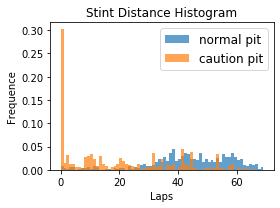

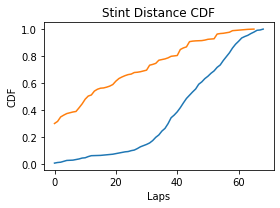

In [41]:
fig, axs = plt.subplots(1, 1, figsize=(4, 3))
#fig, axs = plt.subplots(1, 2)


# car 12, will power
binsize = stintlen_config[trainrace][2]
bins=np.arange(binsize)
car12 = dfall
#nlap = car12[car12['lap_time']<80].lap_cnt
#nlap = car12.lap_cnt
clap = car12[car12['pit_oncaution']==0].lap_cnt
#clap2 = car12[(car12['pit_oncaution']==1) & (car12['lap_time']<80)].lap_cnt
clap2 = car12[(car12['pit_oncaution']==1)].lap_cnt
#plt.hist(nlap,bins= bins, label='all')
axs.hist(clap,bins= bins,normed=1,  alpha=0.7,label='normal pit')
axs.hist(clap2,bins= bins,normed=1,  alpha=0.7,label='caution pit')
axs.set_xlabel('Laps')
axs.set_ylabel('Frequence')
axs.set_title('Stint Distance Histogram')
axs.legend(prop={'size': 12})
plt.tight_layout()
plt.savefig('pitmodel_a.pdf')


fig, axs = plt.subplots(1, 1, figsize=(4, 3))
df = dfall
df = df[(df['pit_oncaution']==0)]
lapcnt_model = make_pitmodel(df.lap_cnt.values)
p = list(lapcnt_model.values())
k = list(lapcnt_model.keys())
lapcnt_cdf = np.cumsum(p) / np.sum(p)
axs.plot(k,lapcnt_cdf, label='normal pit(total = %d)'%(len(df)))

df = dfall
df = df[(df['pit_oncaution']==1)]
lapcnt_model = make_pitmodel(df.lap_cnt.values)
p = list(lapcnt_model.values())
k = list(lapcnt_model.keys())
lapcnt_cdf = np.cumsum(p) / np.sum(p)
axs.plot(k,lapcnt_cdf, label='caution pit(total = %d)'%(len(df)))

axs.set_xlabel('Laps')
axs.set_ylabel('CDF')
axs.set_title('Stint Distance CDF')
#axs[1].legend(prop={'size': 10})
plt.tight_layout()
plt.savefig(f'figs/pitmodel_ab_{trainrace}.pdf')

In [25]:
#model store
dataset = {}

In [26]:
for testevent in testevents:
    for feature_cnt in [2,3]:
        
        sel_stintlen, noshort_stintlen = stintlen_config[trainrace]
        
        df_train, df_test, _data= build_datasets(testevent, include_end, 
                                                 sel_stintlen, noshort_stintlen,
                                                 feature_cnt=feature_cnt)

        key = f'{testevent}-{feature_cnt}'
        dataset[key] = [df_train, df_test, _data]
        featurecnt_str = 'withcurcautionlaps' if (feature_cnt==3) else 'nocurcautionlaps'

        #datafile = f'{dataOutputRoot}/pitstop_nextpit_dataset-{dbid}-t{testevent}-alldata-{featurecnt_str}{includeend_str}.pickle'
        #with open(datafile, 'wb') as f:
        #    print('save data:', datafile)
        #    savedata = [df_train, df_test, events, testevent, _data]
        #    pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

skip event: Indy500-2013
skip event: Indy500-2014
skip event: Indy500-2015
skip event: Indy500-2016
skip event: Indy500-2017
skip event: Indy500-2018
skip event: Indy500-2019
skip event: Texas-2013
skip event: Texas-2014
skip event: Texas-2015
skip event: Texas-2016
skip event: Texas-2017
skip event: Texas-2018
skip event: Texas-2019
carno:1, totallen:250, nancount:0, test_reccnt:0
carno:3, totallen:250, nancount:0, test_reccnt:0
carno:4, totallen:250, nancount:0, test_reccnt:0
carno:5, totallen:250, nancount:0, test_reccnt:0
carno:6, totallen:211, nancount:39, test_reccnt:0
carno:7, totallen:196, nancount:54, test_reccnt:0
carno:9, totallen:188, nancount:62, test_reccnt:0
carno:10, totallen:216, nancount:34, test_reccnt:0
carno:11, totallen:250, nancount:0, test_reccnt:0
carno:12, totallen:218, nancount:32, test_reccnt:0
carno:14, totallen:162, nancount:88, test_reccnt:0
carno:15, totallen:250, nancount:0, test_reccnt:0
carno:16, totallen:189, nancount:61, test_reccnt:0
carno:18, tota

skip event: Indy500-2013
skip event: Indy500-2014
skip event: Indy500-2015
skip event: Indy500-2016
skip event: Indy500-2017
skip event: Indy500-2018
skip event: Indy500-2019
skip event: Texas-2013
skip event: Texas-2014
skip event: Texas-2015
skip event: Texas-2016
skip event: Texas-2017
skip event: Texas-2018
skip event: Texas-2019
carno:1, totallen:250, nancount:0, test_reccnt:0
carno:3, totallen:250, nancount:0, test_reccnt:0
carno:4, totallen:250, nancount:0, test_reccnt:0
carno:5, totallen:250, nancount:0, test_reccnt:0
carno:6, totallen:211, nancount:39, test_reccnt:0
carno:7, totallen:196, nancount:54, test_reccnt:0
carno:9, totallen:188, nancount:62, test_reccnt:0
carno:10, totallen:216, nancount:34, test_reccnt:0
carno:11, totallen:250, nancount:0, test_reccnt:0
carno:12, totallen:218, nancount:32, test_reccnt:0
carno:14, totallen:162, nancount:88, test_reccnt:0
carno:15, totallen:250, nancount:0, test_reccnt:0
carno:16, totallen:189, nancount:61, test_reccnt:0
carno:18, tota

27339 9979


In [27]:
datafile = f'{dataOutputRoot}/pitstop_nextpit_dataset-{dbid}-alldata-{includeend_str}.pickle'
with open(datafile, 'wb') as f:
    print('save data:', datafile)
    savedata = dataset
    pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

save data: data//pitstop_nextpit_dataset-Iowa_2013_2017-alldata--includeend.pickle


In [28]:
## train and save model

In [29]:
p, t, s, e = {}, {} ,{}, {}

testevent=f'{trainrace}-2018'
feature_cnt=2

key = f'{testevent}-{feature_cnt}'
df_train, df_test, _data = dataset[key]
trainset, testset, train_ds, test_ds, scaler = _data['sel']
pm, mid = train_model(500,dropout = 0.1,id='sel', feature_cnt=feature_cnt)
t[mid],s[mid], e[mid] = eval_model(pm, test_ds)
p[mid] = pm

mae = raw_eval(t[mid],s[mid])

pitmodel = save_full_pitmodel(mid, scaler, maxgap=100,feature_cnt=feature_cnt)


INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 132.56it/s, avg_epoch_loss=1.39]
INFO:root:Epoch[0] Elapsed time 0.756 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.393013
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 120.06it/s, avg_epoch_loss=0.924]
INFO:root:Epoch[1] Elapsed time 0.835 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.924343
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 92.59it/s, avg_epoch_loss=0.769]
INFO:root:Epoch[2] Elapsed time 1.082 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.768526
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 109.41it/s, avg_epoch_loss=0.74]
INFO:root:Epoch[3] Elapsed time 0.920 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.739693
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 123.25it/s,

100%|██████████| 100/100 [00:00<00:00, 113.06it/s, avg_epoch_loss=0.593]
INFO:root:Epoch[36] Elapsed time 0.886 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=0.593325
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 130.15it/s, avg_epoch_loss=0.564]
INFO:root:Epoch[37] Elapsed time 0.770 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=0.563513
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 117.38it/s, avg_epoch_loss=0.562]
INFO:root:Epoch[38] Elapsed time 0.854 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=0.562360
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 121.49it/s, avg_epoch_loss=0.571]
INFO:root:Epoch[39] Elapsed time 0.825 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=0.571049
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 146.06it/s, avg_epoch_loss=0.595]
INFO:root:Epoch[40] Elapsed time 0.

INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=0.556908
INFO:root:Epoch[73] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 118.58it/s, avg_epoch_loss=0.543]
INFO:root:Epoch[73] Elapsed time 0.845 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.542811
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 129.16it/s, avg_epoch_loss=0.572]
INFO:root:Epoch[74] Elapsed time 0.776 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.572365
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 134.31it/s, avg_epoch_loss=0.556]
INFO:root:Epoch[75] Elapsed time 0.746 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.555883
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 147.35it/s, avg_epoch_loss=0.514]
INFO:root:Epoch[76] Elapsed time 0.680 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=0.513872
INFO:root:Epoch[77] Learning rate is 0.0005


100%|██████████| 100/100 [00:00<00:00, 161.29it/s, avg_epoch_loss=0.564]
INFO:root:Epoch[108] Elapsed time 0.622 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=0.564378
INFO:root:Epoch[109] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 140.50it/s, avg_epoch_loss=0.544]
INFO:root:Epoch[109] Elapsed time 0.713 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=0.544483
INFO:root:Epoch[110] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 150.08it/s, avg_epoch_loss=0.541]
INFO:root:Epoch[110] Elapsed time 0.668 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.540995
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 162.36it/s, avg_epoch_loss=0.567]
INFO:root:Epoch[111] Elapsed time 0.617 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=0.566877
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 66.65it/s, avg_epoch_loss=0.566]
INFO:root:Ep

100%|██████████| 100/100 [00:01<00:00, 83.98it/s, avg_epoch_loss=0.542]
INFO:root:Epoch[144] Elapsed time 1.192 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=0.542024
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 150.38it/s, avg_epoch_loss=0.549]
INFO:root:Epoch[145] Elapsed time 0.667 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=0.548666
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 139.98it/s, avg_epoch_loss=0.551]
INFO:root:Epoch[146] Elapsed time 0.716 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=0.551428
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 136.04it/s, avg_epoch_loss=0.541]
INFO:root:Epoch[147] Elapsed time 0.737 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=0.541104
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 142.57it/s, avg_epoch_loss=0.538]
INFO:root:Epoch[148] Ela

100%|██████████| 100/100 [00:00<00:00, 137.58it/s, avg_epoch_loss=0.551]
INFO:root:Epoch[180] Elapsed time 0.729 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=0.550985
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 154.29it/s, avg_epoch_loss=0.534]
INFO:root:Epoch[181] Elapsed time 0.650 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=0.534319
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 162.59it/s, avg_epoch_loss=0.538]
INFO:root:Epoch[182] Elapsed time 0.617 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=0.537523
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 147.23it/s, avg_epoch_loss=0.545]
INFO:root:Epoch[183] Elapsed time 0.681 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=0.545413
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 130.68it/s, avg_epoch_loss=0.546]
INFO:root:Epoch[184] El

100%|██████████| 100/100 [00:00<00:00, 156.47it/s, avg_epoch_loss=0.52]
INFO:root:Epoch[216] Elapsed time 0.640 seconds
INFO:root:Epoch[216] Evaluation metric 'epoch_loss'=0.519531
INFO:root:Epoch[217] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 107.45it/s, avg_epoch_loss=0.549]
INFO:root:Epoch[217] Elapsed time 0.932 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=0.548869
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 127.82it/s, avg_epoch_loss=0.568]
INFO:root:Epoch[218] Elapsed time 0.784 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=0.568488
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 135.25it/s, avg_epoch_loss=0.537]
INFO:root:Epoch[219] Elapsed time 0.741 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=0.536757
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 91.43it/s, avg_epoch_loss=0.549]
INFO:root:Epoch[220] Elap

100%|██████████| 100/100 [00:00<00:00, 157.88it/s, avg_epoch_loss=0.575]
INFO:root:Epoch[252] Elapsed time 0.635 seconds
INFO:root:Epoch[252] Evaluation metric 'epoch_loss'=0.574814
INFO:root:Epoch[253] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.27it/s, avg_epoch_loss=0.528]
INFO:root:Epoch[253] Elapsed time 0.625 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=0.528071
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 154.83it/s, avg_epoch_loss=0.523]
INFO:root:Epoch[254] Elapsed time 0.648 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=0.522802
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 133.44it/s, avg_epoch_loss=0.558]
INFO:root:Epoch[255] Elapsed time 0.751 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=0.557915
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.52it/s, avg_epoch_loss=0.522]
INFO:root:Epoch[256] El

100%|██████████| 100/100 [00:01<00:00, 87.06it/s, avg_epoch_loss=0.53]
INFO:root:Epoch[288] Elapsed time 1.165 seconds
INFO:root:Epoch[288] Evaluation metric 'epoch_loss'=0.529742
INFO:root:Epoch[289] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 93.41it/s, avg_epoch_loss=0.567]
INFO:root:Epoch[289] Elapsed time 1.091 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=0.567053
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 106.96it/s, avg_epoch_loss=0.533]
INFO:root:Epoch[290] Elapsed time 0.948 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=0.533302
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 97.06it/s, avg_epoch_loss=0.524]
INFO:root:Epoch[291] Elapsed time 1.032 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=0.523573
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 98.41it/s, avg_epoch_loss=0.543]
INFO:root:Epoch[292] Elapsed

INFO:root:Epoch[324] Evaluation metric 'epoch_loss'=0.544756
INFO:root:Epoch[325] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 96.08it/s, avg_epoch_loss=0.526]
INFO:root:Epoch[325] Elapsed time 1.052 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=0.525841
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 133.13it/s, avg_epoch_loss=0.533]
INFO:root:Epoch[326] Elapsed time 0.759 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=0.532720
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 99.16it/s, avg_epoch_loss=0.544]
INFO:root:Epoch[327] Elapsed time 1.019 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=0.544427
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 159.36it/s, avg_epoch_loss=0.509]
INFO:root:Epoch[328] Elapsed time 0.632 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=0.509274
INFO:root:Epoch[329] Learning rate is

100%|██████████| 100/100 [00:01<00:00, 83.56it/s, avg_epoch_loss=0.562]
INFO:root:Epoch[361] Elapsed time 1.199 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=0.562319
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 100.47it/s, avg_epoch_loss=0.534]
INFO:root:Epoch[362] Elapsed time 0.997 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=0.533672
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 141.80it/s, avg_epoch_loss=0.532]
INFO:root:Epoch[363] Elapsed time 0.707 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=0.532204
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 149.10it/s, avg_epoch_loss=0.541]
INFO:root:Epoch[364] Elapsed time 0.672 seconds
INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=0.541238
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 85.41it/s, avg_epoch_loss=0.541]
INFO:root:Epoch[365] Elap

100%|██████████| 100/100 [00:00<00:00, 159.28it/s, avg_epoch_loss=0.535]
INFO:root:Epoch[397] Elapsed time 0.630 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=0.534998
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.00it/s, avg_epoch_loss=0.555]
INFO:root:Epoch[398] Elapsed time 0.627 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=0.554621
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 157.49it/s, avg_epoch_loss=0.564]
INFO:root:Epoch[399] Elapsed time 0.637 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=0.563524
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.73it/s, avg_epoch_loss=0.531]
INFO:root:Epoch[400] Elapsed time 0.624 seconds
INFO:root:Epoch[400] Evaluation metric 'epoch_loss'=0.531301
INFO:root:Epoch[401] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.60it/s, avg_epoch_loss=0.573]
INFO:root:Epoch[401] El

100%|██████████| 100/100 [00:00<00:00, 161.18it/s, avg_epoch_loss=0.554]
INFO:root:Epoch[433] Elapsed time 0.622 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=0.553988
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 160.10it/s, avg_epoch_loss=0.534]
INFO:root:Epoch[434] Elapsed time 0.626 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=0.533928
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 117.85it/s, avg_epoch_loss=0.538]
INFO:root:Epoch[435] Elapsed time 0.850 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=0.538353
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 122.77it/s, avg_epoch_loss=0.564]
INFO:root:Epoch[436] Elapsed time 0.816 seconds
INFO:root:Epoch[436] Evaluation metric 'epoch_loss'=0.564097
INFO:root:Epoch[437] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 126.09it/s, avg_epoch_loss=0.52]
INFO:root:Epoch[437] Ela

100%|██████████| 100/100 [00:00<00:00, 155.44it/s, avg_epoch_loss=0.54]
INFO:root:Epoch[469] Elapsed time 0.645 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=0.539548
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 125.59it/s, avg_epoch_loss=0.553]
INFO:root:Epoch[470] Elapsed time 0.809 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=0.553192
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 97.54it/s, avg_epoch_loss=0.54]
INFO:root:Epoch[471] Elapsed time 1.037 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=0.540219
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 95.95it/s, avg_epoch_loss=0.522]
INFO:root:Epoch[472] Elapsed time 1.054 seconds
INFO:root:Epoch[472] Evaluation metric 'epoch_loss'=0.521763
INFO:root:Epoch[473] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 137.40it/s, avg_epoch_loss=0.529]
INFO:root:Epoch[473] Elapse

{
    "MSE": 0.28390341055996726,
    "abs_error": 1295.1431927020444,
    "abs_target_sum": 2559.4779334782133,
    "abs_target_mean": 0.8964896439503375,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.8043505326513231,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 564.200556004075,
    "Coverage[0.1]": 0.08266199649737303,
    "QuantileLoss[0.5]": 1295.1431927020444,
    "Coverage[0.5]": 0.30367775831873906,
    "QuantileLoss[0.9]": 353.3066515394084,
    "Coverage[0.9]": 0.9008756567425569,
    "RMSE": 0.5328258726450578,
    "NRMSE": 0.5943469355621185,
    "ND": 0.5060185031335683,
    "wQuantileLoss[0.1]": 0.2204357961536915,
    "wQuantileLoss[0.5]": 0.5060185031335683,
    "wQuantileLoss[0.9]": 0.13803856126990743,
    "mean_wQuantileLoss": 0.2881642868523891,
    "MAE_Coverage": 0.07151196730881493
}
mae =  9.918739054290718
make full testdb: 5050 records


Running evaluation: 100%|██████████| 5050/5050 [00:33<00:00, 152.63it/s]


{
    "MSE": 1.6241279363106662,
    "abs_error": 5383.662421524097,
    "abs_target_sum": 8491.84612454287,
    "abs_target_mean": 1.681553688028291,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.9792754064213652,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 7616.435093942262,
    "Coverage[0.1]": 0.9126732673267327,
    "QuantileLoss[0.5]": 5383.662421524097,
    "Coverage[0.5]": 0.9497029702970297,
    "QuantileLoss[0.9]": 1324.780670157641,
    "Coverage[0.9]": 0.9708910891089109,
    "RMSE": 1.2744127809743067,
    "NRMSE": 0.7578781397509953,
    "ND": 0.6339802137917223,
    "wQuantileLoss[0.1]": 0.89691157638025,
    "wQuantileLoss[0.5]": 0.6339802137917223,
    "wQuantileLoss[0.9]": 0.15600620297732445,
    "mean_wQuantileLoss": 0.5622993310497656,
    "MAE_Coverage": 0.4444224422442244
}
save model data//pitmodel-m100-mlp-Iowa-dsel-f2-e500-l10-10-5-student-d0.1-1k-nocurcautionlaps.pickle with 5050 keys.


### evaluate all trained models

In [19]:
sys.exit(0)

SystemExit: 0

/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
p, t, s, e = {}, {} ,{}, {}

In [ ]:
#sync_test_ds = _data['all'][3]
cols = ['Year','Model','MAE','50-Risk','90-Risk']

### run train on all data
allruns = ['sel','all','noshort','normal','caution','plen2']
testevent='Indy500-2018'

retdata = []
for feature_cnt in [2,3]:
    for tid in allruns:
        #train
        key = f'{testevent}-{feature_cnt}'
        df_train, df_test, _data = dataset[key]
        
        trainset, testset, train_ds, test_ds, scaler = _data[tid]
        pm, mid = train_model(500,dropout = 0.1, id=tid, feature_cnt=feature_cnt)

        #test
        sync_testset = _data['normal'][1]
        sync_test_ds, _, _ = makedb(sync_testset, scaler, perm=False, feature_cnt=feature_cnt)
        t[mid],s[mid], e[mid] = eval_model(pm, sync_test_ds)
        p[mid] = pm

        mae = raw_eval(t[mid],s[mid])
        retdata.append([testevent,tid, mae, e[mid]["wQuantileLoss[0.5]"],e[mid]["wQuantileLoss[0.9]"]])

        #run_test(t[mid], s[mid], [31,816,846,856])
        pitmodel = save_full_pitmodel(mid, scaler, maxgap=65,feature_cnt=feature_cnt)
    
pitmodel_result = pd.DataFrame(data=retdata, columns=cols)

In [ ]:
#savedata('mlp-train-savedata.pickle',[p,t,s,e])
p.keys()

In [ ]:
pitmodel_result

## evaluate 

In [ ]:
#testid = 'sel'
retdata = []
truth, pred, samples = {}, {}, {}     
#cols = ['Year','Model','MAE','50-Risk','90-Risk','50-Risk','90-Risk']
cols = ['Year','Model','MAE','50-Risk','90-Risk']

trainruns = ['sel','all','normal']
testruns = ['sel','all','normal','caution','plen2']

for feature_cnt in [2,3]:
    for tid in trainruns:
        mid = f"mlp-d{tid}-f{feature_cnt}-e500-l10-10-5-student-d0.1"

        for testevent in ['Indy500-2018','Indy500-2019']:
            key = f'{testevent}-{feature_cnt}'
            df_train, df_test, _data = dataset[key]
            scaler = _data[tid][-1]

            for testid in testruns:
                #trainset, testset, train_ds, test_ds, scaler
                sync_testset = _data[testid][1]
                test_ds, _, _ = makedb(sync_testset, scaler, perm=False,feature_cnt=feature_cnt)

                tx,sx, ex = eval_model(p[mid], test_ds)
                mae = raw_eval(tx,sx)
                print(mid, 'mae=', mae,ex["wQuantileLoss[0.5]"],ex["wQuantileLoss[0.9]"] )

                # prisk direct
                truth[mid], pred[mid], samples[mid] = decode(tx,sx)
                idx = np.where(samples[mid] < 0)
                samples[mid][idx] = 0

                _, prisk_vals = prisk_direct_bysamples(samples[mid],truth[mid])
                print(prisk_vals[1], prisk_vals[2])        

                retdata.append([testevent,tid + '-' + testid, mae, 
                               #ex["wQuantileLoss[0.5]"],ex["wQuantileLoss[0.9]"],
                               prisk_vals[1], prisk_vals[2]])
        
test_result = pd.DataFrame(data=retdata, columns=cols) 

In [ ]:
test_result

In [ ]:
test_result.to_csv('pitmodel_mlp_evaluation_result_full.csv')

In [ ]:
#testid = 'sel'
retdata = []
truth, pred, samples = {}, {}, {}     
#cols = ['Year','Model','MAE','50-Risk','90-Risk','50-Risk','90-Risk']
cols = ['Year','Model','FeatureCnt','MAE','50-Risk','90-Risk']

trainruns = ['sel','all']
for feature_cnt in [2,3]:
    for tid in trainruns:
        mid = f"mlp-d{tid}-f{feature_cnt}-e500-l10-10-5-student-d0.1"

        for testevent in ['Indy500-2018','Indy500-2019']:
            key = f'{testevent}-{feature_cnt}'
            df_train, df_test, _data = dataset[key]
            scaler = _data[tid][-1]

            for testid in ['all','sel', 'caution','shortnormal']:
                #trainset, testset, train_ds, test_ds, scaler
                if testid == 'shortnormal':
                    test_sel = df_test[(df_test['pit_oncaution']==0) & (df_test['stint_len']<=23)]
                    sync_testset = test_sel[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
                else:
                    sync_testset = _data[testid][1]
                           
                test_ds, _, _ = makedb(sync_testset, scaler, perm=False,feature_cnt=feature_cnt)

                tx,sx, ex = eval_model(p[mid], test_ds)
                mae = raw_eval(tx,sx)
                print(mid, 'mae=', mae,ex["wQuantileLoss[0.5]"],ex["wQuantileLoss[0.9]"] )

                # prisk direct
                truth[mid], pred[mid], samples[mid] = decode(tx,sx)
                idx = np.where(samples[mid] < 0)
                samples[mid][idx] = 0

                _, prisk_vals = prisk_direct_bysamples(samples[mid],truth[mid])
                print(prisk_vals[1], prisk_vals[2])        

                retdata.append([testevent,tid + '-' + testid , feature_cnt, mae, 
                               #ex["wQuantileLoss[0.5]"],ex["wQuantileLoss[0.9]"],
                               prisk_vals[1], prisk_vals[2]])
        
test_result = pd.DataFrame(data=retdata, columns=cols) 
test_result.to_csv('pitmodel_mlp_evaluation_result_paper.csv')

### test

In [ ]:
#straight implementation of prisk
def quantile_loss(target, quantile_forecast, q):
    return 2.0 * np.nansum(
        np.abs(
            (quantile_forecast - target)
            * ((target <= quantile_forecast) - q)
        )
    )

def abs_target_sum(target): 
    return np.nansum(np.abs(target)) 

def prisk_direct_bysamples(forecast, target, quantiles=[0.1,0.5,0.9], startid = 0, verbose=False):
    """
    calculate prisk by <samples, tss> directly (equal to gluonts implementation)
    
    target: endrank
    forecast: pred_endrank
    item_id: <carno, startlap>
    """
    
    prisk = np.zeros((len(quantiles)))
    target_sum = 0
    aggrisk = np.zeros((len(quantiles)))
    
    #calc quantiles
    # len(quantiles) x 1
    quantile_forecasts = np.quantile(forecast, quantiles, axis=0)

    for idx, q in enumerate(quantiles):
        q_forecast = quantile_forecasts[idx]
        prisk[idx] = quantile_loss(target[startid:], q_forecast[startid:], q)
        target_sum = abs_target_sum(target[startid:])

    if verbose==True and carno==3:
        print('target:', target[startid:])
        print('forecast:', q_forecast[startid:])
        print('target_sum:', target_sum)

        print('quantile_forecasts:', quantile_forecasts[:,startid:])
        
    #agg
    #aggrisk = np.mean(prisk, axis=0)
    #prisk_sum = np.nansum(prisk, axis=0)
    prisk_sum = prisk
    
    if verbose==True:
        print('prisk:',prisk)
        print('prisk_sum:',prisk_sum)
        print('target_sum:',target_sum)
    for idx, q in enumerate(quantiles):
        aggrisk[idx] = np.divide(prisk_sum[idx], target_sum)
    
    agg_metrics = {}
    for idx, q in enumerate(quantiles):
        agg_metrics[f'wQuantileLoss[{q}]'] = aggrisk[idx]
        
    print(agg_metrics.values())
    
    return agg_metrics, aggrisk

In [ ]:
#trainset, testset, train_ds, test_ds, scaler = _data['all']
trainset, testset, train_ds, test_ds, scaler = _data['sel']

In [ ]:
pm, mid = train_model(500,dropout = 0.1,id='sel')
t[mid],s[mid], e[mid] = eval_model(pm, test_ds)
p[mid] = pm

mae = raw_eval(t[mid],s[mid])

run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
pitmodel = save_full_pitmodel(mid, 'sel', maxgap=65)

In [ ]:
### run train on all data
trainset, testset, train_ds, test_ds, scaler = _data['all']

pm, mid = train_model(500,dropout = 0.1,id='all')
t[mid],s[mid], e[mid] = eval_model(pm, test_ds)
p[mid] = pm

mae = raw_eval(t[mid],s[mid])

run_test(t[mid], s[mid], [31,816,846,856])
pitmodel = save_full_pitmodel(mid, 'all', maxgap=65)

In [ ]:
### run train on all data
tid = 'noshort'
trainset, testset, train_ds, test_ds, scaler = _data[tid]

pm, mid = train_model(500,dropout = 0.1,id=tid)
t[mid],s[mid], e[mid] = eval_model(pm, test_ds)
p[mid] = pm

mae = raw_eval(t[mid],s[mid])

run_test(t[mid], s[mid], [31,816,846,856])
pitmodel = save_full_pitmodel(mid, tid, maxgap=65)

In [ ]:
sys.exit(0)

### test and tuning

In [ ]:
s.keys()

In [ ]:
pm, mid = train_model(500,dropout = 0.1)
t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
pm, mid = train_model(2000,dropout = 0.1)
t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
save_model(p[mid], mid)
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
mid

In [ ]:
t.keys()

In [ ]:
pm, mid = train_model(200,dropout = 0.1, layers=[8,4])
t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
e={}

In [ ]:
t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
pm, mid = train_model(500, layers=[10,5])
t[mid],s[mid] = eval_model(pm)
p[mid] = pm

In [ ]:
pm, mid = train_model(500, layers=[32,16,8,4])
t[mid],s[mid] = eval_model(pm)
p[mid] = pm

In [ ]:
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
pm, mid = train_model(2000, layers=[32,16,8,4])
t[mid],s[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

### test

In [ ]:
trec = next(iter(train_ds))
trec


In [ ]:
run_test(tss, forecasts, [31,816,846,856])

In [ ]:
test_sel.iloc[816]

In [ ]:
test_sel.iloc[836]

In [ ]:
t[mid],s[mid] = eval_model(pm)

In [ ]:
get_pred(t[mid],s[mid], 816)

In [ ]:
next(iter(test_ds))

In [ ]:
scaler

In [ ]:
pm, mid = train_model(2,dropout = 0.1)
#t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
#run_test(t[mid], s[mid], [31,816,846,856])

#mid = 'mlp-e2000-l10-10-5-student-d0.1'
save_model(p[mid], mid)

### test pitmodel

In [ ]:
_scaler = scaler

In [ ]:
id = 'mlp-e2000-l10-10-5-student-d0.1'
t[id],s[id], e[id] = eval_model(p[id])

In [ ]:
forecasts = s[id]
tss = t[id]

scaler = _scaler
testset = test_sel[['lap2nextpit','caution_laps','pitage']].values

pitmodel = PitModel()

pitmodel.save_model('pitmodel_test', testset, forecasts, scaler)

In [ ]:
newcasts = pitmodel.forecast_ds(testset, forecasts)
scaler = _scaler
run_test(tss, newcasts, [31,816,846,856],raw_forecast=True)

In [ ]:
plt.plot(pitmodel.model['0-0'][0,:], pitmodel.model['0-0'][1,:])

In [ ]:
plt.plot(pitmodel.model['10-13'][0,:], pitmodel.model['10-13'][1,:])

In [ ]:
pitmodel.model['0-0'][0,:]

In [ ]:
scaler = _scaler
test_all = df_test[['lap2nextpit','caution_laps','pitage']].values
test_ds, _, test_set = makedb(test_all, scaler, perm=False)

id = 'mlp-e2000-l10-10-5-student-d0.1'
t[id],s[id], e[id] = eval_model(p[id])
forecasts = s[id]
tss = t[id]

pitmodel = PitModel()

pitmodel.save_model(f'mlp-{id}.pickle', test_all, forecasts, scaler)


In [ ]:
len(forecasts)

In [ ]:
testall_set

In [ ]:
scaler = _scaler
maxgap = 60
test_ds, _, test_set, test_all = make_fulltestdb(scaler, maxgap = maxgap)

id = 'mlp-e2000-l10-10-5-student-d0.1'

t[id],s[id], e[id] = eval_model(p[id])
forecasts = s[id]
tss = t[id]

pitmodel = PitModel()

pitmodel.save_model(f'pitmodel-m{maxgap}-{id}.pickle', test_all, forecasts, scaler)

In [ ]:
pitmodel.model['0-0'][0,:]

In [ ]:
plt.plot(pitmodel.model['0-0'][0,:], pitmodel.model['0-0'][1,:])

In [ ]:
t.keys()

In [ ]:
t['mlp-dsel-e500-l10-10-5-student-d0.1'][0]

### shortterm predictions using pitmodel(plen=2)

convert forecast samples of pitmodel to forecast samples of pit@plen laps

In [ ]:
test_car12 = df_test[df_test['carno']==12]

In [ ]:
test_ds, _, test_set = makedb(test_car12[['lap2nextpit','caution_laps','pitage']].values, scaler, perm=False)

In [ ]:
len(test_set)

In [ ]:
test

In [ ]:
test_car12[test_car12['lap']==31]

In [ ]:
test_car12[test_car12['lap']==30]

In [ ]:
test_ds

In [ ]:
len(test_ds)

In [ ]:
test_set

### test

In [ ]:
df12 = df_test[(df_test['eid']==5) & (df_test['carno']==12)]

In [ ]:
df12[(df12['lap']>=45) & (df12['lap']<55)]

In [ ]:
df12

In [ ]:
df12.cur_cautionlaps.values

In [ ]:
train_set

In [ ]:
samples = np.zeros((1000))
for i in range(1000):
    samples[i] = pitmodel.predict(1,16,1)
    
samples[samples<5]

In [ ]:
np.sum(samples<5)

In [ ]:
np.min(samples)

In [ ]:
np.max(samples)

In [ ]:
test_all

In [ ]:
df_test

In [ ]:
#test on normal set
tid = 'sel'
testid = 'normal'
feature_cnt = 2
testevent = 'Indy500-2018'
mid = f"mlp-d{tid}-f{feature_cnt}-e500-l10-10-5-student-d0.1"

key = f'{testevent}-{feature_cnt}'
df_train, df_test, _data = dataset[key]
scaler = _data[tid][-1]

#trainset, testset, train_ds, test_ds, scaler
sync_testset = _data[testid][1]
print('testset len=', len(sync_testset))
test_ds, _, _ = makedb(sync_testset, scaler, perm=False,feature_cnt=feature_cnt)

tx,sx, ex = eval_model(p[mid], test_ds)
mae = raw_eval(tx,sx)

In [ ]:
tid = 'sel'
testid = 'sel'
feature_cnt = 2
testevent = 'Indy500-2018'
mid = f"mlp-d{tid}-f{feature_cnt}-e500-l10-10-5-student-d0.1"

key = f'{testevent}-{feature_cnt}'
df_train, df_test, _data = dataset[key]
scaler = _data[tid][-1]

#trainset, testset, train_ds, test_ds, scaler
sync_testset = _data[testid][1]
print('testset len=', len(sync_testset))
test_ds, _, _ = makedb(sync_testset, scaler, perm=False,feature_cnt=feature_cnt)

tx,sx, ex = eval_model(p[mid], test_ds)
mae = raw_eval(tx,sx)

In [ ]:
tid = 'sel'
testid = 'sel'
feature_cnt = 2
testevent = 'Indy500-2018'
mid = f"mlp-d{tid}-f{feature_cnt}-e500-l10-10-5-student-d0.1"

key = f'{testevent}-{feature_cnt}'
df_train, df_test, _data = dataset[key]
scaler = _data[tid][-1]

#trainset, testset, train_ds, test_ds, scaler
test_sel = df_test[(df_test['pit_oncaution']==0) & (df_test['stint_len']<23)]
sync_testset = test_sel[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
print('testset len=', len(sync_testset))
test_ds, _, _ = makedb(sync_testset, scaler, perm=False,feature_cnt=feature_cnt)

tx,sx, ex = eval_model(p[mid], test_ds)
mae = raw_eval(tx,sx)

In [ ]:
pitmodel.model.keys()

In [ ]:
pitmodel.model['0-1']

In [ ]:
a = 'kdk-TRA-xxx'
a.replace('TRA', 'BBB')

In [ ]:
a


In [20]:
mae

11.76717400246812